Follow the instructions before running the code:
    
https://github.com/unmannedlab/RELLIS-3D/tree/979a533262b77a29901d1fa6f747b39600d4ffd3/benchmarks

In [1]:
import os
import torch

In [2]:
from hrnet.config import config
from hrnet.config import update_config
from hrnet.core.function import testval, test
from hrnet.utils.modelsummary import get_model_summary
from hrnet.utils.utils import create_logger, FullModel
from hrnet import models

In [3]:
model_state_file = "../config/weights/seg_hrnet_ocr_w48_train_512x1024_sgd_lr1e-2_wd5e-4_bs_12_epoch484/best.pth"

In [4]:
cfg_path = "../config/hrnet_rellis/seg_hrnet_ocr_w48_train_512x1024_sgd_lr1e-3_wd5e-4_bs_12_epoch484.yaml"

config.defrost()
config.merge_from_file(cfg_path)
config.merge_from_list(['TEST.MODEL_FILE',
                       '../config/weights/seg_hrnet_ocr_w48_train_512x1024_sgd_lr1e-2_wd5e-4_bs_12_epoch484/best.pth'])
config.freeze()

In [5]:
model = eval('models.' + config.MODEL.NAME + '.get_seg_model')(config)

{'ocr_distri_head.conv_bn_dropout.1.0.num_batches_tracked', 'ocr_distri_head.object_context_block.f_up.0.weight', 'ocr_distri_head.object_context_block.f_pixel.1.0.running_var', 'ocr_distri_head.object_context_block.f_up.1.0.running_mean', 'ocr_distri_head.object_context_block.f_object.3.0.running_mean', 'aux_head.0.bias', 'ocr_distri_head.object_context_block.f_down.1.0.weight', 'ocr_distri_head.object_context_block.f_object.3.0.bias', 'aux_head.1.weight', 'aux_head.1.num_batches_tracked', 'ocr_distri_head.conv_bn_dropout.1.0.running_mean', 'conv3x3_ocr.1.running_mean', 'ocr_distri_head.object_context_block.f_object.1.0.running_var', 'ocr_distri_head.object_context_block.f_object.0.weight', 'ocr_distri_head.object_context_block.f_object.3.0.running_var', 'ocr_distri_head.object_context_block.f_up.1.0.running_var', 'ocr_distri_head.object_context_block.f_object.1.0.weight', 'conv3x3_ocr.1.weight', 'ocr_distri_head.object_context_block.f_pixel.3.0.running_var', 'conv3x3_ocr.0.weight', '

In [6]:
pretrained_dict = torch.load(model_state_file)
if 'state_dict' in pretrained_dict:
    pretrained_dict = pretrained_dict['state_dict']
model_dict = model.state_dict()
pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items()
                    if k[6:] in model_dict.keys()}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [7]:
from torch import nn

gpus = list(config.GPUS)
print('GPUS:',gpus)
model = nn.DataParallel(model, device_ids=gpus).cuda()

GPUS: [0]


In [8]:
from hrnet import datasets

# prepare data
test_size = (config.TEST.IMAGE_SIZE[1], config.TEST.IMAGE_SIZE[0])
test_dataset = eval('datasets.'+config.DATASET.DATASET)(
                    root=config.DATASET.ROOT,
                    list_path=config.DATASET.TEST_SET,
                    num_samples=None,
                    num_classes=config.DATASET.NUM_CLASSES,
                    multi_scale=False,
                    flip=False,
                    ignore_label=config.TRAIN.IGNORE_LABEL,
                    base_size=config.TEST.BASE_SIZE,
                    crop_size=test_size,
                    downsample_rate=1)

testloader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=config.WORKERS,
                                         pin_memory=True)

In [9]:
import yaml

data_cfg = "../config/rellis.yaml"
CFG = yaml.safe_load(open(data_cfg, 'r'))
id_color_map = CFG["color_map"]

  0%|                                                                                                                                                       | 0/1672 [00:00<?, ?it/s]

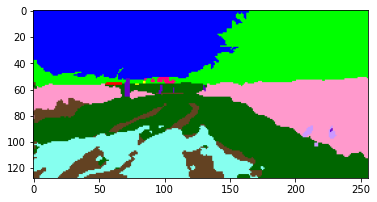

  6%|████████▍                                                                                                                                    | 100/1672 [00:11<02:54,  9.03it/s]

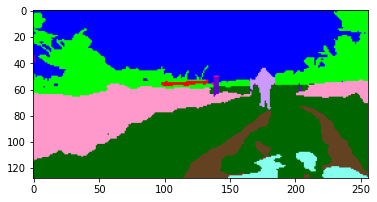

 12%|████████████████▊                                                                                                                            | 200/1672 [00:22<02:43,  9.00it/s]

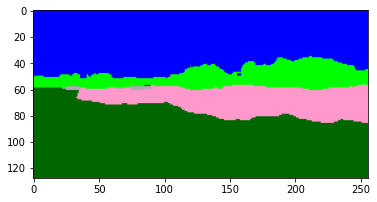

 18%|█████████████████████████▎                                                                                                                   | 300/1672 [00:33<02:33,  8.94it/s]

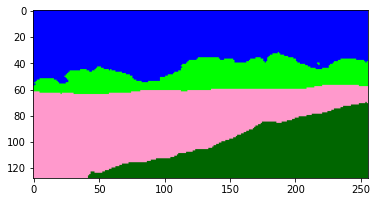

 24%|█████████████████████████████████▋                                                                                                           | 400/1672 [00:44<02:22,  8.91it/s]

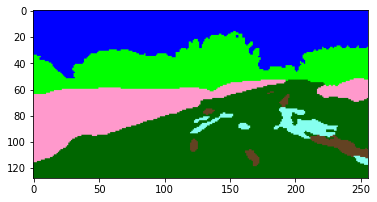

 30%|██████████████████████████████████████████▏                                                                                                  | 500/1672 [00:56<02:12,  8.87it/s]


In [10]:
from tqdm import tqdm
from hrnet.core.function import convert_label, convert_color
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

viz = True
model.eval()

with torch.no_grad():
    
    for it, batch in enumerate(tqdm(testloader)):
        
        if it == 500:
            break
        
        image, size, name = batch
        
        size = size[0]
        pred = model(image)
        pred = pred[config.TEST.OUTPUT_INDEX]
        pred_np = pred.cpu().numpy()
        b,_,_,_ = pred.shape
        
        for i in range(b):
            sv_path = os.path.join(config.OUTPUT_DIR, 'hrnet', name[i][:5],'pylon_camera_node_label_id')
            if not os.path.exists(sv_path):
                os.makedirs(sv_path)
            _, file_name = os.path.split(name[i])
            file_name = file_name.replace("jpg","png")
            data_path = os.path.join(sv_path,file_name)
            pred_arg = np.argmax(pred_np[i],axis=0).astype(np.uint8)
            pred_arg = convert_label(pred_arg, True)
            pred_img = np.stack((pred_arg,pred_arg,pred_arg),axis=2)
            pred_img = Image.fromarray(pred_img)
            pred_img.save(data_path)
            
            if viz:
                sv_path = os.path.join(config.OUTPUT_DIR, 'hrnet',name[i][:5],'pylon_camera_node_label_color')
                if not os.path.exists(sv_path):
                    os.makedirs(sv_path)
                _, file_name = os.path.split(name[i])
                file_name = file_name.replace("jpg","png")
                color_path = os.path.join(sv_path,file_name)
                color_label = convert_color(pred_arg, id_color_map)

                color_img = Image.fromarray(color_label,'RGB')
                color_img.save(color_path)
                
        if it % 100 == 0:
            plt.figure()
            plt.imshow(color_label)
            plt.show()